In [83]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
using DiffEqCallbacks
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using ProgressBars
using NonlinearSolve
using BenchmarkTools
using Libdl

In [84]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb, threshold_du, threshold_std, t_std, f_counter)
    list_t, popup_t, nbr_error_t, sol_t = [], [], [], []
    sol_ss, time_ss = [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
        
        # Load the functions
        fsolve(du, u, p, t) = functions[f_counter](du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        function stop_condition(u, t, integrator)
            if t > 2*t_std # To compute the std over a big enough nbr of points
                # Condition on the derivatives near 0
                du = similar(u)
                fsolve(du, u, integrator.p, t)
                condition_du = norm(du)/sqrt(length(du)) < threshold_du

                # Condition on the density of atoms in the ES that has to be stable
                u_t, t_sol = integrator.sol.u, integrator.sol.t
                n_es = [sum(real([u_t[j][i] for i = 1:N])) for j = 1:length(t_sol)] # Computes the density
                n_es_window_t = n_es[abs.(t_sol .- integrator.t) .< t_std]
                std_es_window_t = std(n_es_window_t)
                condition_std = std_es_window_t < threshold_std
                return condition_du & condition_std
            else
                return false
            end
        end

        # Saving function: return the pop density
        function save_func(u, t, integrator)
            return sum(real(copy(integrator.u)[1:N]))
        end

        t_ss = SavedValues(Float64, Float64)
        cb = SavingCallback(save_func, time_ss;
                            saveat = nothing,
                            tstops = nothing,
                            save_everysteps = false,
                            condition = stop_condition)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (0, t_end))
        
        println("$i, $chunk")

        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                    reltol=1.0e-5,
                    abstol=1.0e-5,
                    callback = cb,
                    dtmin = 1e-2)
        push!(time_ss, t_ss)
        push!(list_t, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])
        push!(sol_t, sol.u)

        if ~SciMLBase.successful_retcode(sol) # If solution DV, add it to the error
            push!(nbr_error_t, i)
        end
    end
    return list_t, popup_t, nbr_error_t, sol_t, time_ss, sol_ss
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

load_f

### Define the system

In [85]:
# Nbr of particles
N_list = [2:2:10;]
r = 10
 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 100 #2e3 # atoms per unit of volume (already normalized)
d0_lb = 1e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb / λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
t_end = 1e2
threshold_du = 1e-3
threshold_std, t_std = 1e-3, 15; # Time over which the std is computed

### Compute stationnary state for r repetitions

In [86]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [87]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functions[i] = load_f("diffeqf", libpath)
end

In [88]:
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
popup_t_N, list_t_N, sol_ss_N, time_ss_N = [], [], [], []
sol_t_N, nbr_error_t_N = [], []

for (i, N) in ProgressBar(enumerate(N_list))
    # popup_t, nbr_error_t, list_t, sol_t, sol_ss, time_ss, n_es_t_list, time_n_es, std_es_list, time_std_es_list = [], [], [], [], [], [], [], [], [], []
    @load "op_list/op_list_$N.jdl2" op_list
    tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
        Threads.@spawn solve_random_distrib(chunk, functions, op_list, N, n0, d0_lb, threshold_du, threshold_std, t_std, i)
    end
    sol_tasks = fetch.(tasks)
    push!(list_t_N, vcat([s[1] for s in sol_tasks]...))
    push!(popup_t_N, vcat([s[2] for s in sol_tasks]...))
    push!(nbr_error_t_N, vcat([s[3] for s in sol_tasks]...))
    push!(sol_t_N, vcat([s[4] for s in sol_tasks]...))
    push!(time_ss_N, vcat([s[5] for s in sol_tasks]...))
    push!(sol_ss_N, vcat([s[6] for s in sol_tasks]...))
end


0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]


LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching SavingCallback(::var"#save_func#solve_random_distrib##78"{Int64}, ::Vector{Any}; saveat::Nothing, tstops::Nothing, save_everysteps::Bool, condition::var"#stop_condition#solve_random_distrib##73"{Int64, Float64, Float64, Int64, var"#fsolve#solve_random_distrib##72"{Int64, Vector{ComplexF64}}})
    The function `SavingCallback` exists, but no method is defined for this combination of argument types.
    
    [0mClosest candidates are:
    [0m  SavingCallback(::Any, [91m::SavedValues[39m; saveat, save_everystep, save_start, save_end, tdir)[91m got unsupported keyword arguments "tstops", "save_everysteps", "condition"[39m
    [0m[90m   @[39m [33mDiffEqCallbacks[39m [90mC:\Users\Joschka\.julia\packages\DiffEqCallbacks\5fUZh\src\[39m[90m[4msaving.jl:150[24m[39m
    
    Stacktrace:
     [1] [0m[1msolve_random_distrib[22m[0m[1m([22m[90mchunk[39m::[0mUnitRange[90m{Int64}[39m, [90mf[39m::[0mVector[90m{Function}[39m, [90mop_list[39m::[0mVector[90m{Any}[39m, [90mN[39m::[0mInt64, [90mn[39m::[0mInt64, [90md0_lb[39m::[0mFloat64, [90mthreshold_du[39m::[0mFloat64, [90mthreshold_std[39m::[0mFloat64, [90mt_std[39m::[0mInt64, [90mf_counter[39m::[0mInt64[0m[1m)[22m
    [90m   @[39m [32mMain[39m [90m.\[39m[90m[4mIn[84]:95[24m[39m
     [2] [0m[1m(::var"#158#159"{UnitRange{Int64}, Int64, Int64, Vector{Any}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [32mMain[39m [90m.\[39m[90m[4mIn[88]:10[24m[39m

In [ ]:
@save "solutions/sol_N_$(N_list)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N time_ss_N sol_ss_N

In [ ]:
# @load "solutions/sol_N_$(N)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N time_ss_N sol_ss_N

# Plots with time evolution

In [ ]:
fig, ax = subplots()
for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        if j ∉ nbr_error_t_N[i]
            if j == 1
                line, = ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label=N_list[i])
            else
                ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, color=line.get_color())
            end
        end
    end
end

for i in 1:length(time_ss_N)
    for j = 1:length(time_ss_N[i])
        ax.scatter(time_ss_N[i][j], sol_ss_N[i][j], color="red")
    end
end

ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.legend()

suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false); gcf();
pygui(true); show()

# Plot the evolutions that didn't work

In [ ]:
close("all")
fig, axes = subplots(1, 2, figsize=(10, 5))
for i in 1:length(popup_t_N)
    for j in 1:length(popup_t_N[i])
        @load "r0/r0_N_$(N_list[i])_r_$j.jdl2" r0 L
        if j ∈ nbr_error_t_N[i]
            axes[1].plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label="N=$(N_list[i]), r=$j")
            axes[2].scatter(N_list[i], min_r0(r0), color ="r")
        else
            axes[2].scatter(N_list[i], min_r0(r0), color ="b")
        end

    end
end
axes[2].hlines(d0_lb, N_list[1], N_list[end])
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
axes[2].set_xlabel(L"N")
axes[2].set_ylabel(L"min(r_0)")
axes[1].legend()
# pygui(false); gcf();
pygui(true); show()

# Timestep 

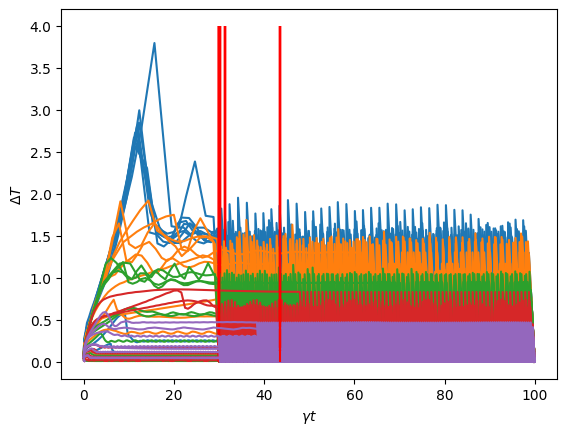

In [ ]:
close("all")
fig, ax = subplots()
for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        T = list_t_N[i][j]
        counter_ss = 1
        if j == 1
            line, = ax.plot(T[1:end-1], T[2:end]-T[1:end-1], label=N_list[i])
        else
            ax.plot(T[1:end-1], T[2:end]-T[1:end-1], color=line.get_color())
        end

        if j ∉ nbr_error_t_N
            ax.vlines(time_ss_N[i][counter_ss], 0, 4, color="red")
            counter_ss += 1
        end
    end
end

ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\Delta T$")
pygui(false); gcf();
# pygui(true); show()

# Find problematic distribution

In [ ]:
fig, ax = subplots()
i=9

line, = ax.plot(list_t[i], popup_t[i], marker="o", markersize=1)
# ax.scatter(time_ss[i], sol_ss[i], color="red")


ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf();
# pygui(true); show()

# Brouillons

<!-- """ Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb, threshold_du, threshold_std, t_std, f_counter)
    list_t, popup_t, nbr_error_t, sol_t = [], [], [], []
    sol_ss, time_ss = [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
        
        # Load the functions
        fsolve(du, u, p, t) = functions[f_counter](du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        function condition(u, t, integrator)
            if t > 2*t_std # To compute the std over a big enough nbr of points
                # Condition on the derivatives near 0
                du = similar(u)
                fsolve(du, u, integrator.p, t)
                condition_du = norm(du)/sqrt(length(du)) < threshold_du

                # Condition on the density of atoms in the ES that has to be stable
                u_t, t_sol = integrator.sol.u, integrator.sol.t
                n_es = [sum(real([u_t[j][i] for i = 1:N])) for j = 1:length(t_sol)] # Computes the density
                n_es_window_t = n_es[abs.(t_sol .- integrator.t) .< t_std]
                std_es_window_t = std(n_es_window_t)
                condition_std = std_es_window_t < threshold_std
                return condition_du & condition_std
            else
                return false
            end
        end

        stop = false
        function affect!(integrator)
            if ~stop
                push!(sol_ss, sum(real(copy(integrator.u)[1:N])))
                push!(time_ss, integrator.t)
                stop = true
            end
        end
        saved = SavedValues(Float64, Float64)
        
        cb = DiscreteCallback(condition, affect!)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (0, t_end))
        
        println("$i, $chunk")

        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                    reltol=1.0e-5,
                    abstol=1.0e-5,
                    callback = cb,
                    dtmin = 1e-2)

        push!(list_t, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])
        push!(sol_t, sol.u)

        if ~SciMLBase.successful_retcode(sol) # If solution DV, add it to the error
            push!(nbr_error_t, i)
        end
    end
    return list_t, popup_t, nbr_error_t, sol_t, time_ss, sol_ss
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end -->